<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#机器学习&amp;深度学习04-K-Means++聚类算法" data-toc-modified-id="机器学习&amp;深度学习04-K-Means++聚类算法-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>机器学习&amp;深度学习04-K-Means++聚类算法</a></span><ul class="toc-item"><li><span><a href="#数据prepare" data-toc-modified-id="数据prepare-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>数据prepare</a></span></li><li><span><a href="#K-means算法存在的问题" data-toc-modified-id="K-means算法存在的问题-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>K-means算法存在的问题</a></span><ul class="toc-item"><li><span><a href="#随机初始化中心点" data-toc-modified-id="随机初始化中心点-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>随机初始化中心点</a></span></li><li><span><a href="#K-Means算法实现" data-toc-modified-id="K-Means算法实现-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>K-Means算法实现</a></span></li></ul></li><li><span><a href="#K-Means++-算法流程" data-toc-modified-id="K-Means++-算法流程-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>K-Means++ 算法流程</a></span></li><li><span><a href="#K-Means++算法实现" data-toc-modified-id="K-Means++算法实现-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>K-Means++算法实现</a></span></li><li><span><a href="#Mini-Batch-K-Means-聚类算法" data-toc-modified-id="Mini-Batch-K-Means-聚类算法-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Mini-Batch K-Means 聚类算法</a></span></li></ul></li></ul></div>

# 机器学习&深度学习04-K-Means++聚类算法

## 数据prepare

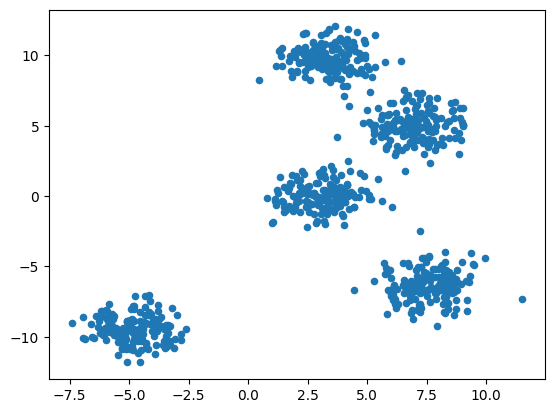

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

# 构造示例数据
blobs_plus, _ = make_blobs(n_samples=800, centers=5, random_state=18)  # 生成数据
plt.scatter(blobs_plus[:, 0], blobs_plus[:, 1], s=20)  # 将数据可视化展示

## K-means算法存在的问题

### 随机初始化中心点

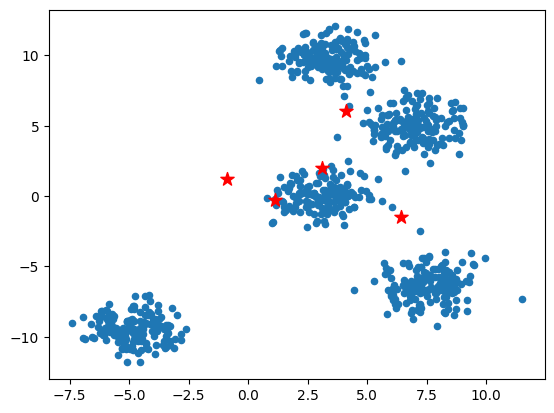

In [2]:
import numpy as np


def random_k(k, data):
    """随机选择k个中心点"""
    # 初始化中心点
    prng = np.random.RandomState(27)
    num_feature = np.shape(data)[1]
    
    # 用于生成服从标准正态分布（均值为0，标准差为1）的随机数，为了更加贴近数据集这里乘了一个 5
    init_centers = prng.randn(k, num_feature) * 5
    
    return init_centers


km_init_center = random_k(5, blobs_plus)

plt.scatter(blobs_plus[:, 0], blobs_plus[:, 1], s=20)
plt.scatter(km_init_center[:, 0],
            km_init_center[:, 1], s=100, marker='*', c="r")

### K-Means算法实现

In [3]:
import numpy as np


def d_euc(x, y):
    """计算样本与中心点的距离：欧式距离"""
    d = np.sqrt(np.sum(np.square(x - y)))
    return d


def update_center(clusters, data, centers):
    """更新中心点
    参数:
    clusters -- 每一点分好的类别，数据格式：[1, 0, 0, 2, 1, 0, ...]
    data -- 数据集
    centers -- 中心点集合

    返回:
    new_centers.reshape(num_centers,num_features) -- 新中心点集合
    """
    # num_centers: 中心点的个数
    # num_features: 每一个中心点的特征数
    num_centers, num_features = np.shape(centers)
    
    # 首先创建一个容器将相同类别数据存放到一起
    container = []
    for x in range(num_centers):
        each_container = []
        container.append(each_container)

    for i, cluster in enumerate(clusters):
        container[cluster].append(data[i])

    # 创建一个容器，存放中心点的坐标
    new_centers = np.array([])
    
    # 计算每一子集中数据均值作为中心点
    for i in range(len(container)):
        each_center = np.mean(container[i], axis=0)
        new_centers = np.append(new_centers, each_center)

    return new_centers.reshape(num_centers, num_features)


def kmeans_cluster(data, init_centers, k):
    """
    参数:
    data -- 数据集
    init_centers -- 初始化中心点集合
    k -- 中心点个数

    返回:
    centers_container -- 每一次更新中心点的集合
    cluster_container -- 每一次更新类别的集合
    """
    max_step = 50    # 最大迭代次数
    epsilon = 0.001  # 定义一个足够小的数，通过中心点变化的距离是否小于该数，判断中心点是否变化

    old_centers = init_centers

    centers_container = []  # 建立一个中心点容器，存放每一次变化后的中心点，以便后面的绘图
    cluster_container = []  # 建立一个分类容器，存放每一次中心点变化后数据的类别
    centers_container.append(old_centers)

    for step in range(max_step):
        cluster = np.array([], dtype=int)
        # 遍历数据集
        for each_data in data:
            distances = np.array([])
            # 遍历中心点
            for each_center in old_centers:
                # 计算样本和中心点的欧式距离
                temp_distance = d_euc(each_data, each_center)
                distances = np.append(distances, temp_distance)
            # 返回距离最近中心点的索引，即按照最近中心点分类
            lab = np.argmin(distances)
            cluster = np.append(cluster, lab)
        cluster_container.append(cluster)
        
        # 根据子集分类更新中心点
        new_centers = update_center(cluster, data, old_centers)

        # 计算每个中心点更新前后之间的欧式距离
        difference = []
        for each_old_center, each_new_center in zip(old_centers, new_centers):
            difference.append(d_euc(each_old_center, each_new_center))
        
        # 判断每个中心点移动是否均小于 epsilon => 提前结束
        if (np.array(difference) < epsilon).all():
            return centers_container, cluster_container

        centers_container.append(new_centers)
        old_centers = new_centers

    return centers_container, cluster_container

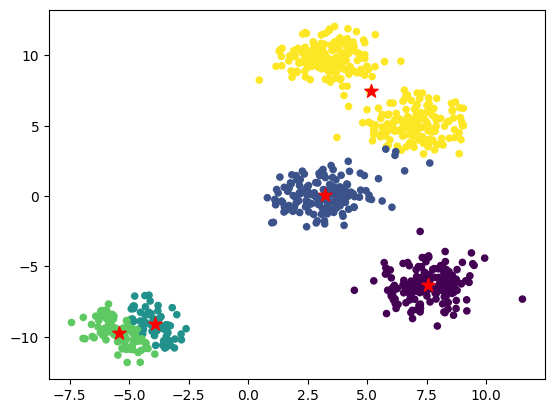

In [4]:
km_centers, km_clusters = kmeans_cluster(blobs_plus, km_init_center, 5)
km_final_center = km_centers[-1]
km_final_cluster = km_clusters[-1]
plt.scatter(blobs_plus[:, 0], blobs_plus[:, 1], s=20, c=km_final_cluster)
plt.scatter(km_final_center[:, 0],
            km_final_center[:, 1], s=100, marker='*', c="r")

通过传统 K-Means 算法聚类后，你会发现聚类效果和我们预想不同，我们预想的结果应该是下面这样的：

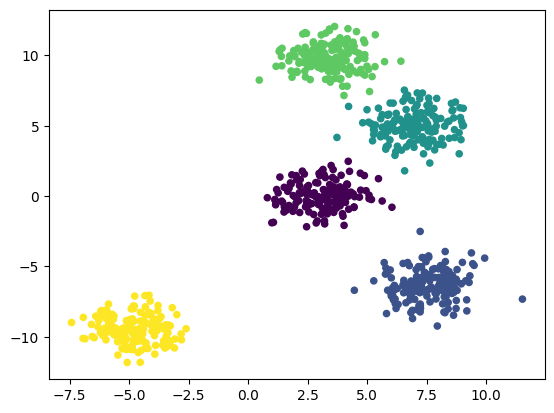

In [5]:
plt.scatter(blobs_plus[:, 0], blobs_plus[:, 1], s=20, c=_)

## K-Means++ 算法流程

K-Means++ 相较于 K-Means 在初始化中心点上做了改进，在其他方面和 K-Means 相同。

1. 在数据集中随机选择一个样本点作为第一个初始化的聚类中心。
2. 计算样本中的非中心点与最近中心点之间的距离$D(x)$并保存于一个数组里，将数组中的这些距离加起来得到$sum(D(x))$ 。
3. 取一个落在$sum(D(x))$范围中的随机值$R$，重复计算$R=R-D(x)$，直至得到$R\leq0$，选取此时的点作为下一个中心点。
4. 重复 2,3 步骤，直到$K$个聚类中心都被确定。
5. 对$K$个初始化的聚类中心，利用 K-Means 算法计算最终的聚类中心。

看完整个算法流程，可能会出现一个疑问：为避免初始点距离太近，直接选取距离最远的点不就好了，为什么要引入一个随机值$R$呢？

其实当采用直接选取距离最远的点作为初始点的方法，会容易受到数据集中离群点的干扰。采用引入随机值$R$的方法避免数据集中所包含的离群点对算法思想中要选择相距最远的中心点的目标干扰。

相对于正常的数据点，离群点所计算得出的$D(x)$距离相对比较大，这样在选取的过程中，它被选中的概率也就相对较大，但是离群点在整个数据集中只占一小部分，大部分依然是正常的点，这样离群点由于距离大而造成的概率大，就被正常点的数量大给平衡掉。从而保证了整个算法的平衡性。

## K-Means++算法实现

In [6]:
def get_sum_dis(centers, data):
    """
    参数:
    centers -- 中心点集合
    data -- 数据集

    返回:
    np.sum(dis_container) -- 样本距离最近中心点的距离之和
    dis_container -- 样本距离最近中心点的距离集合
    """
    dis_container = np.array([])
    for each_data in data:
        distances = np.array([])
        # 遍历所有的中心点
        for each_center in centers:
            # 计算当前样本到所有中心点的欧式距离
            temp_distance = d_euc(each_data, each_center)
            distances = np.append(distances, temp_distance)
        lab = np.min(distances)
        dis_container = np.append(dis_container, lab)
    return np.sum(dis_container), dis_container


def get_init_center(data, k):
    """
    参数:
    data -- 数据集
    k -- 中心点个数

    返回:
    np.array(center_container) -- 初始化中心点集合
    """
    # K-Means++ 初始化中心点
    seed = np.random.RandomState(20)
    p = seed.randint(0, len(data))
    first_center = data[p]

    center_container = []
    center_container.append(first_center)

    for i in range(k-1):
        sum_dis, dis_con = get_sum_dis(center_container, data)
        r = np.random.randint(0, sum_dis)
        for j in range(len(dis_con)):
            r = r - dis_con[j]
            if r <= 0:
                center_container.append(data[j])
                break
            else:
                pass

    return np.array(center_container)

In [7]:
plus_init_center = get_init_center(blobs_plus, 5)
plus_init_center

array([[ 4.1661903 ,  0.81807492],
       [ 9.31155197, -5.67254834],
       [ 4.44766592, 10.65120386],
       [-4.40446211, -9.48243429],
       [ 6.83276791, -8.284894  ]])

Text(0.5, 1.0, 'final center')

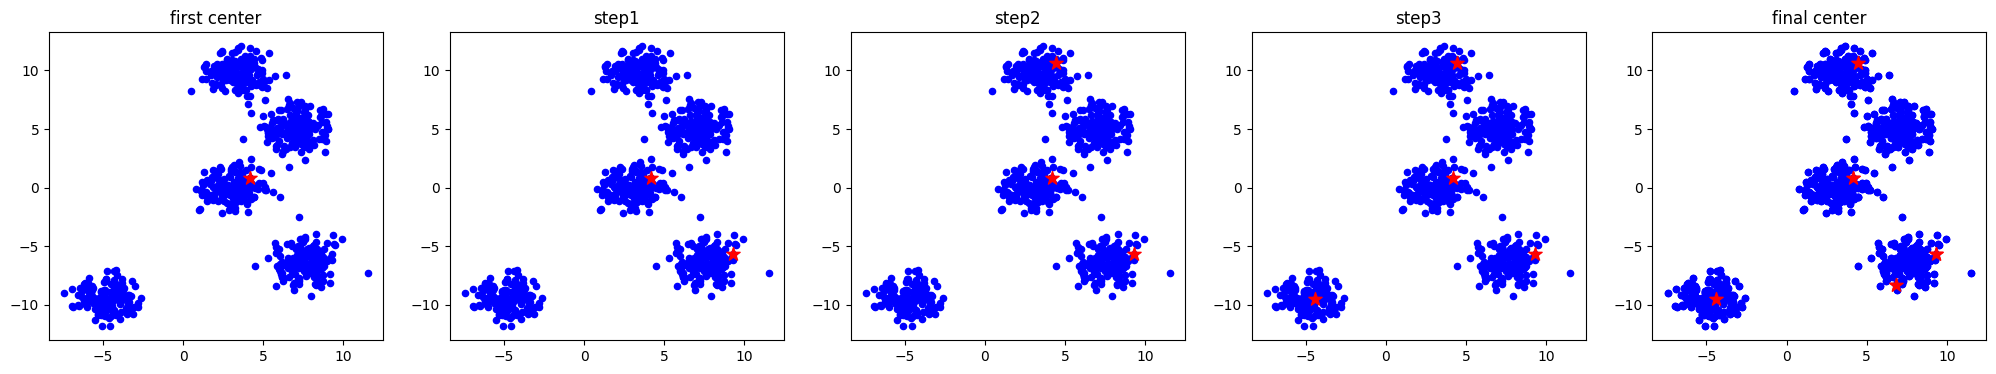

In [8]:
num = len(plus_init_center)

fig, axes = plt.subplots(1, num, figsize=(25, 4))

axes[0].scatter(blobs_plus[:, 0], blobs_plus[:, 1], s=20, c="b")
axes[0].scatter(plus_init_center[0, 0], plus_init_center[0, 1], s=100, marker='*', c="r")
axes[0].set_title("first center")

for i in range(1, num):
    axes[i].scatter(blobs_plus[:, 0], blobs_plus[:, 1], s=20, c="b")
    axes[i].scatter(plus_init_center[:i+1, 0],
                    plus_init_center[:i+1, 1], s=100, marker='*', c="r")
    axes[i].set_title("step{}".format(i))

axes[-1].scatter(blobs_plus[:, 0], blobs_plus[:, 1], s=20, c="b")
axes[-1].scatter(plus_init_center[:, 0],
                 plus_init_center[:, 1], s=100, marker='*', c="r")
axes[-1].set_title("final center")

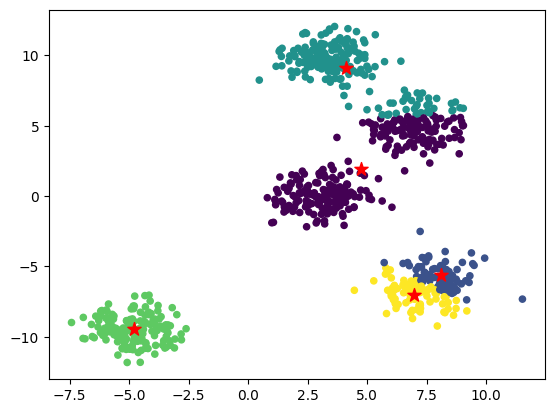

In [9]:
plus_centers, plus_clusters = kmeans_cluster(blobs_plus, plus_init_center, 5)
plus_final_center = plus_centers[-1]
plus_final_cluster = plus_clusters[-1]

plt.scatter(blobs_plus[:, 0], blobs_plus[:, 1], s=20, c=plus_final_cluster)
plt.scatter(plus_final_center[:, 0],
            plus_final_center[:, 1], s=100, marker='*', c="r")

## Mini-Batch K-Means 聚类算法

在「大数据」如此火的时代，K-Means 算法是否还能一如既往优秀的处理大数据呢？现在我们重新回顾下 K-Means 的算法原理：首先，计算每一个样本同所有中心点的距离，通过比较找到最近的中心点，将距离最近中心点的距离进行存储并归类。然后通过相同类别样本的特征值，更新中心点的位置。至此完成一次迭代，经过多次迭代后最终进行聚类。

通过上面的表述，你是否感觉到不断计算距离的过程，涉及到的计算量有多大呢？那么，设想一下数据量达到十万，百万，千万级别，且如果每一条数据有上百个特征，这将会消耗大量的计算资源。

为了解决大规模数据的聚类问题，我们就可以使用 K-Means 的另外一个变种 Mini Batch K-Means 来完成。

其算法原理也十分简单：在每一次迭代过程中，从数据集中随机抽取一部分数据形成小批量数据集，用该部分数据集进行距离计算和中心点的更新。由于每一次都是随机抽取，所以每一次抽取的数据能很好的表现原本数据集的特性。

下面，我们生成一组测试数据，并测试 K-Means 算法和 Mini Batch K-Means 在同一组数据上聚类时间和 SSE 上的差异。由于 scikit-learn 中 `MiniBatchKMeans()` 和 `KMeans()` 方法的参数几乎一致，这里就不再赘述了。

Text(0.5, 1.0, 'Mini Batch K-Means')

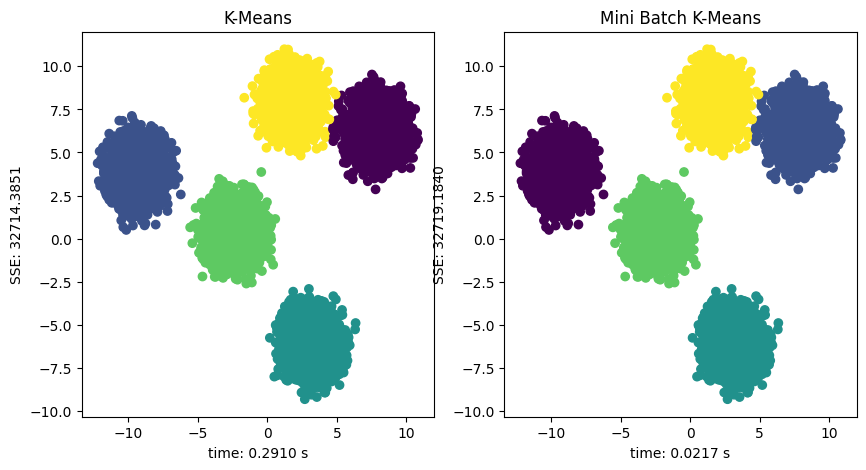

In [10]:
import time
from sklearn.cluster import MiniBatchKMeans, KMeans


test_data, _ = make_blobs(20000, n_features=2, cluster_std=0.9, centers=5, random_state=20)

km = KMeans(n_clusters=5)
mini_km = MiniBatchKMeans(n_clusters=5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i, model in enumerate([km, mini_km]):
    t0 = time.time()
    model.fit(test_data)
    t1 = time.time()
    t = t1 - t0
    sse = model.inertia_
    axes[i].scatter(test_data[:, 0], test_data[:, 1], c=model.labels_)
    axes[i].set_xlabel("time: {:.4f} s".format(t))
    axes[i].set_ylabel("SSE: {:.4f}".format(sse))

axes[0].set_title("K-Means")
axes[1].set_title("Mini Batch K-Means")